# Testing boosting, ensemble and linear models to predict NYC taxi fares

### importing the dataframe and getting ready for xgboost

In [29]:
#libraries we need
import pandas as pd
import numpy as np
import datetime as date
import matplotlib.pyplot as plt
from pandas import read_csv
import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBRegressor
from scipy.stats import sem

df = pd.read_csv("C:/Users/zubiz/Desktop/NYC Third Year project/taxi_tripdata.csv")

#cleans the dataframe and fills in empty values
df = df.drop(['ehail_fee',"payment_type","store_and_fwd_flag"], axis = 1)
for list_cols in df.columns:    
    df[list_cols] = df[list_cols].fillna(0)
df.head()

#splits the object into a datetime object
df['lpep_pickup_datetime'] = pd.to_datetime(df['lpep_pickup_datetime'], errors='coerce')
df['lpep_dropoff_datetime'] = pd.to_datetime(df['lpep_dropoff_datetime'], errors='coerce')
df['time_taken'] = df['lpep_dropoff_datetime'] - df['lpep_pickup_datetime']
df['time_taken'] = df['time_taken'].dt.total_seconds().div(60).astype(float)
df['day'] = pd.to_datetime(df['lpep_pickup_datetime']).dt.weekday
df['hour'] = pd.to_datetime(df['lpep_pickup_datetime']).dt.hour
df["PU_time"] = pd.to_datetime(df['lpep_pickup_datetime'])
df["DO_time"] = pd.to_datetime(df['lpep_dropoff_datetime'])
df = df.drop(['lpep_pickup_datetime','lpep_dropoff_datetime'], axis = 1)


#outliers cleaned
interval_one = df["time_taken"].quantile(0.001)
interval_two = df["time_taken"].quantile(0.995)
df = df.drop(df[(df['time_taken'] < interval_one) | (df['time_taken'] > interval_two)].index)

df.head()

C:\Users\zubiz\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,VendorID,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_type,congestion_surcharge,time_taken,day,hour,PU_time,DO_time
0,1.0,1.0,74,168,1.0,1.20,6.0,0.5,0.5,0.00,0.0,0.3,7.30,1.0,0.0,4.733333,3,0,2021-07-01 00:30:52,2021-07-01 00:35:36
1,2.0,1.0,116,265,2.0,13.69,42.0,0.5,0.5,0.00,0.0,0.3,43.30,1.0,0.0,35.916667,3,0,2021-07-01 00:25:36,2021-07-01 01:01:31
2,2.0,1.0,97,33,1.0,0.95,6.5,0.5,0.5,2.34,0.0,0.3,10.14,1.0,0.0,6.033333,3,0,2021-07-01 00:05:58,2021-07-01 00:12:00
3,2.0,1.0,74,42,1.0,1.24,6.5,0.5,0.5,0.00,0.0,0.3,7.80,1.0,0.0,5.716667,3,0,2021-07-01 00:41:40,2021-07-01 00:47:23
4,2.0,1.0,42,244,1.0,1.10,7.0,0.5,0.5,0.00,0.0,0.3,8.30,1.0,0.0,7.233333,3,0,2021-07-01 00:51:32,2021-07-01 00:58:46


### Feature set and target

In [30]:
dftrain = df[["PULocationID","DOLocationID","passenger_count","trip_distance","day","hour","time_taken",
              "trip_type","fare_amount"]]
dftrain = dftrain.drop(dftrain[(dftrain['passenger_count'] == 0)].index)
dftrain = dftrain.drop(dftrain[(dftrain['trip_type'] == 0)].index)
dftrain = dftrain.drop(dftrain[(dftrain['fare_amount'] < 0)].index)
dftrain = dftrain.drop(dftrain[(dftrain['trip_distance'] < 0)].index)
dftrain.describe()

,PULocationID,DOLocationID,passenger_count,trip_distance,day,hour,time_taken,trip_type,fare_amount
count,50516.000000,50516.000000,50516.000000,50516.000000,50516.000000,50516.000000,50516.000000,50516.000000,50516.000000
mean,98.600424,135.018073,1.310476,3.473876,2.990063,13.691108,16.159907,1.033514,14.950447
std,64.572398,77.619544,0.986602,4.528978,1.852488,5.123003,15.061823,0.179977,14.169416
min,3.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.016667,1.000000,0.000000
25%,52.000000,74.000000,1.000000,1.100000,1.000000,10.000000,7.116667,1.000000,7.000000
50%,75.000000,134.000000,1.000000,1.990000,3.000000,14.000000,11.866667,1.000000,10.500000
75%,129.000000,213.000000,1.000000,3.850000,4.000000,18.000000,19.500000,1.000000,17.000000
max,265.000000,265.000000,32.000000,85.810000,6.000000,23.000000,119.000000,2.000000,480.000000


In [32]:
X = dftrain[["PULocationID","DOLocationID","passenger_count","trip_distance","day","hour","time_taken",
              "trip_type",]]
X = pd.get_dummies(X, columns= ['PULocationID', 'DOLocationID','trip_type','day','hour','passenger_count'])
y = dftrain['fare_amount']

In [33]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(X.head(11))

,trip_distance,time_taken,PULocationID_3,PULocationID_5,PULocationID_6,PULocationID_7,PULocationID_8,PULocationID_9,PULocationID_10,PULocationID_11,PULocationID_14,PULocationID_15,PULocationID_16,PULocationID_17,PULocationID_18,PULocationID_19,PULocationID_20,PULocationID_21,PULocationID_22,PULocationID_23,PULocationID_24,PULocationID_25,PULocationID_26,PULocationID_27,PULocationID_28,PULocationID_29,PULocationID_31,PULocationID_32,PULocationID_33,PULocationID_34,PULocationID_35,PULocationID_36,PULocationID_37,PULocationID_38,PULocationID_39,PULocationID_40,PULocationID_41,PULocationID_42,PULocationID_43,PULocationID_44,PULocationID_45,PULocationID_46,PULocationID_47,PULocationID_48,PULocationID_49,PULocationID_51,PULocationID_52,PULocationID_53,PULocationID_54,PULocationID_55,PULocationID_56,PULocationID_57,PULocationID_58,PULocationID_59,PULocationID_60,PULocationID_61,PULocationID_62,PULocationID_63,PULocationID_64,PULocationID_65,PULocationID_66,PULocationID_67,PULocationID_69,PULocationID_70,PULocationID_71,PULocationID_72,PULocationID_73,PULocationID_74,PULocationID_75,PULocationID_76,PULocationID_77,PULocationID_78,PULocationID_80,PULocationID_81,PULocationID_82,PULocationID_83,PULocationID_84,PULocationID_85,PULocationID_86,PULocationID_88,PULocationID_89,PULocationID_91,PULocationID_92,PULocationID_93,PULocationID_94,PULocationID_95,PULocationID_96,PULocationID_97,PULocationID_98,PULocationID_99,PULocationID_100,PULocationID_101,PULocationID_102,PULocationID_106,PULocationID_108,PULocationID_111,PULocationID_112,PULocationID_115,PULocationID_116,PULocationID_117,PULocationID_118,PULocationID_119,PULocationID_120,PULocationID_121,PULocationID_122,PULocationID_123,PULocationID_124,PULocationID_126,PULocationID_127,PULocationID_128,PULocationID_129,PULocationID_130,PULocationID_131,PULocationID_132,PULocationID_133,PULocationID_134,PULocationID_135,PULocationID_136,PULocationID_137,PULocationID_138,PULocationID_139,PULocationID_140,PULocationID_141,PULocationID_145,PULocationID_146,PULocationID_147,PULocationID_149,PULocationID_150,PULocationID_151,PULocationID_152,PULocationID_153,PULocationID_154,PULocationID_155,PULocationID_156,PULocationID_157,PULocationID_159,PULocationID_160,PULocationID_163,PULocationID_165,PULocationID_166,PULocationID_167,PULocationID_168,PULocationID_169,PULocationID_170,PULocationID_171,PULocationID_172,PULocationID_173,PULocationID_174,PULocationID_175,PULocationID_177,PULocationID_178,PULocationID_179,PULocationID_180,PULocationID_181,PULocationID_182,PULocationID_183,PULocationID_184,PULocationID_185,PULocationID_188,PULocationID_189,PULocationID_190,PULocationID_191,PULocationID_192,PULocationID_193,PULocationID_194,PULocationID_195,PULocationID_196,PULocationID_197,PULocationID_198,PULocationID_200,PULocationID_201,PULocationID_202,PULocationID_203,PULocationID_205,PULocationID_206,PULocationID_207,PULocationID_208,PULocationID_210,PULocationID_212,PULocationID_213,PULocationID_215,PULocationID_216,PULocationID_217,PULocationID_218,PULocationID_219,PULocationID_220,PULocationID_221,PULocationID_222,PULocationID_223,PULocationID_225,PULocationID_226,PULocationID_227,PULocationID_228,PULocationID_231,PULocationID_235,PULocationID_236,PULocationID_238,PULocationID_239,PULocationID_240,PULocationID_241,PULocationID_242,PULocationID_243,PULocationID_244,PULocationID_245,PULocationID_247,PULocationID_248,PULocationID_249,PULocationID_250,PULocationID_252,PULocationID_253,PULocationID_254,PULocationID_255,PULocationID_256,PULocationID_257,PULocationID_258,PULocationID_259,PULocationID_260,PULocationID_262,PULocationID_263,PULocationID_264,PULocationID_265,DOLocationID_1,DOLocationID_3,DOLocationID_4,DOLocationID_5,DOLocationID_6,DOLocationID_7,DOLocationID_8,DOLocationID_9,DOLocationID_10,DOLocationID_11,DOLocationID_12,DOLocationID_13,DOLocationID_14,DOLocationID_15,DOLocationID_16,DOLocationID_17,DOLocationID_18,DOLocationID_19,DOLocationID_20,DOLocationID_21,DOLocationID_22,DOLocationID_23,D

In [34]:
X.describe()

,trip_distance,time_taken,PULocationID_3,PULocationID_5,PULocationID_6,PULocationID_7,PULocationID_8,PULocationID_9,PULocationID_10,PULocationID_11,...,hour_22,hour_23,passenger_count_1.0,passenger_count_2.0,passenger_count_3.0,passenger_count_4.0,passenger_count_5.0,passenger_count_6.0,passenger_count_7.0,passenger_count_32.0
count,50516.000000,50516.000000,50516.000000,50516.000000,50516.000000,50516.000000,50516.000000,50516.000000,50516.000000,50516.000000,...,50516.000000,50516.000000,50516.000000,50516.000000,50516.000000,50516.000000,50516.000000,50516.000000,50516.000000,50516.000000
mean,3.473876,16.159907,0.000139,0.000455,0.000099,0.026328,0.000059,0.000059,0.000831,0.000376,...,0.027239,0.023557,0.863033,0.076689,0.012234,0.003583,0.024289,0.020112,0.000040,0.000020
std,4.528978,15.061823,0.011771,0.021333,0.009948,0.160111,0.007706,0.007706,0.028823,0.019390,...,0.162780,0.151665,0.343815,0.266099,0.109929,0.059752,0.153947,0.140386,0.006292,0.004449
min,0.000000,0.016667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.100000,7.116667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.990000,11.866667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.850000,19.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,85.810000,119.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [36]:
# Removing outliers using zscore
def remove_outliers(X, y):
    
    kpi = pd.Series(y).name
    
    from scipy.stats import zscore
    
    y = pd.DataFrame(y)
    y['zscore'] = zscore(y[kpi],axis=0)

    #Remove outliers
    mean_std_ratio = y[kpi].describe()['std'] / y[kpi].describe()['mean']

    #Create new df with outliers removed
    rows_to_keep = y['zscore'] <  (1 / mean_std_ratio)

    #Print % of rows removed
    print(f"Number of rows to be removed {X.shape[0] - X[rows_to_keep].shape[0] } ")
    print(f"% of rows kept after outliers removed { (1 - (X.shape[0] - X[rows_to_keep].shape[0]) / X.shape[0]):.1%}")

    X = X[rows_to_keep]
    y = y[rows_to_keep]

    #Set y and X
    y = y[kpi]
        
    return X, y

features_clean, target_clean = remove_outliers(X, y)
X_train, X_test, y_train, y_test = train_test_split(features_clean, target_clean, test_size=0.2)
features_clean.describe()

Number of rows to be removed 4869 
% of rows kept after outliers removed 90.4%


,trip_distance,time_taken,PULocationID_3,PULocationID_5,PULocationID_6,PULocationID_7,PULocationID_8,PULocationID_9,PULocationID_10,PULocationID_11,...,hour_22,hour_23,passenger_count_1.0,passenger_count_2.0,passenger_count_3.0,passenger_count_4.0,passenger_count_5.0,passenger_count_6.0,passenger_count_7.0,passenger_count_32.0
count,45647.000000,45647.000000,45647.000000,45647.000000,45647.000000,45647.000000,45647.000000,45647.000000,45647.000000,45647.000000,...,45647.000000,45647.000000,45647.000000,45647.000000,45647.000000,45647.000000,45647.000000,45647.000000,45647.000000,45647.0
mean,2.407438,12.653012,0.000131,0.000022,0.000022,0.027362,0.000066,0.000022,0.000416,0.000263,...,0.027121,0.023244,0.865752,0.072119,0.011633,0.003177,0.025544,0.021754,0.000022,0.0
std,2.040185,8.473569,0.011464,0.004681,0.004681,0.163138,0.008107,0.004681,0.020398,0.016212,...,0.162438,0.150678,0.340922,0.258687,0.107227,0.056272,0.157772,0.145881,0.004681,0.0
min,0.000000,0.016667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,1.070000,6.733333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,1.820000,10.966667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
75%,3.160000,16.733333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
max,41.800000,116.316667,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0


### Training a model

In [7]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

def train_regressor(learner, X_train, X_test, y_train, y_test):
    
    reg = learner
    reg = reg.fit(X_train, y_train)
    predictions_train = reg.predict(X_train)
    predictions_test = reg.predict(X_test)
        
    return predictions_train, predictions_test, reg

def evaluate_regressor(learner, X_train, X_test, y_train, y_test):
    
    predictions_train, predictions_test, reg = train_regressor(learner, X_train, X_test, y_train, y_test)
    
    metrics = pd.DataFrame(
    {"r2_score":[r2_score(y_test, predictions_test)],
    "adjusted_r2":[1 - (1-reg.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)],
    "MSE":[mean_squared_error(y_test, predictions_test)],
    "RMSE":[sqrt(mean_squared_error(y_test, predictions_test))],
    "MAE": [mean_absolute_error(y_test, predictions_test)],
    "learner":[str(reg)],
    "Target":[y_train.name]}
    )
    
    return metrics, reg

def evaluate_multiple_regressors(learners, X_train, X_test, y_train, y_test):
    
    metrics = pd.DataFrame(columns=['r2_score','adjusted_r2','MSE','RMSE','MAE','learner','Target'])
    model_store = {}
    
    for learner in learners:
        
        learner_metrics, learner_reg = evaluate_regressor(learner, X_train, X_test, y_train, y_test) 
        
        metrics = metrics.append(learner_metrics)
        model_store[str(learner)] = learner_reg
        
        print(str(learner) + " has now trained for " + str(y_train.name))
        
    return metrics, model_store

In [16]:
learners = [CatBoostRegressor(loss_function='RMSE', allow_writing_files=False), XGBRegressor(), RandomForestRegressor()]
metrics, model_store = evaluate_multiple_regressors(learners, X_train, X_test, y_train, y_test)


Learning rate set to 0.072418
0:	learn: 5.7646931	total: 11ms	remaining: 11s
1:	learn: 5.4200314	total: 19.8ms	remaining: 9.89s
2:	learn: 5.1085431	total: 28.8ms	remaining: 9.57s
3:	learn: 4.8239287	total: 38.2ms	remaining: 9.52s
4:	learn: 4.5506453	total: 47.3ms	remaining: 9.41s
5:	learn: 4.3057815	total: 56.7ms	remaining: 9.39s
6:	learn: 4.0794229	total: 65.9ms	remaining: 9.36s
7:	learn: 3.8716833	total: 75.3ms	remaining: 9.34s
8:	learn: 3.6764048	total: 84.3ms	remaining: 9.29s
9:	learn: 3.5008304	total: 93.6ms	remaining: 9.27s
10:	learn: 3.3375803	total: 103ms	remaining: 9.25s
11:	learn: 3.1916387	total: 113ms	remaining: 9.31s
12:	learn: 3.0544007	total: 123ms	remaining: 9.32s
13:	learn: 2.9322530	total: 133ms	remaining: 9.34s
14:	learn: 2.8199732	total: 142ms	remaining: 9.31s
15:	learn: 2.7154487	total: 152ms	remaining: 9.32s
16:	learn: 2.6198442	total: 162ms	remaining: 9.37s
17:	learn: 2.5294893	total: 174ms	remaining: 9.47s
18:	learn: 2.4496919	total: 183ms	remaining: 9.47s
19:	l

176:	learn: 1.5097164	total: 1.71s	remaining: 7.95s
177:	learn: 1.5091619	total: 1.72s	remaining: 7.94s
178:	learn: 1.5075206	total: 1.73s	remaining: 7.93s
179:	learn: 1.5073246	total: 1.74s	remaining: 7.92s
180:	learn: 1.5071926	total: 1.75s	remaining: 7.91s
181:	learn: 1.5067153	total: 1.76s	remaining: 7.9s
182:	learn: 1.5063833	total: 1.77s	remaining: 7.89s
183:	learn: 1.5056031	total: 1.78s	remaining: 7.88s
184:	learn: 1.5054875	total: 1.79s	remaining: 7.87s
185:	learn: 1.5042106	total: 1.8s	remaining: 7.86s
186:	learn: 1.5028439	total: 1.81s	remaining: 7.85s
187:	learn: 1.5021002	total: 1.81s	remaining: 7.84s
188:	learn: 1.5020023	total: 1.82s	remaining: 7.83s
189:	learn: 1.5018990	total: 1.83s	remaining: 7.82s
190:	learn: 1.5015806	total: 1.84s	remaining: 7.81s
191:	learn: 1.5014827	total: 1.85s	remaining: 7.8s
192:	learn: 1.5009984	total: 1.86s	remaining: 7.79s
193:	learn: 1.5007302	total: 1.87s	remaining: 7.78s
194:	learn: 1.4998270	total: 1.88s	remaining: 7.77s
195:	learn: 1.4

340:	learn: 1.4156288	total: 3.46s	remaining: 6.68s
341:	learn: 1.4147912	total: 3.47s	remaining: 6.67s
342:	learn: 1.4140264	total: 3.48s	remaining: 6.66s
343:	learn: 1.4139117	total: 3.49s	remaining: 6.65s
344:	learn: 1.4135888	total: 3.5s	remaining: 6.64s
345:	learn: 1.4131805	total: 3.51s	remaining: 6.64s
346:	learn: 1.4124321	total: 3.52s	remaining: 6.63s
347:	learn: 1.4115214	total: 3.53s	remaining: 6.62s
348:	learn: 1.4110893	total: 3.54s	remaining: 6.61s
349:	learn: 1.4098463	total: 3.55s	remaining: 6.6s
350:	learn: 1.4095290	total: 3.56s	remaining: 6.59s
351:	learn: 1.4093803	total: 3.58s	remaining: 6.58s
352:	learn: 1.4089587	total: 3.59s	remaining: 6.57s
353:	learn: 1.4075685	total: 3.6s	remaining: 6.56s
354:	learn: 1.4073145	total: 3.61s	remaining: 6.55s
355:	learn: 1.4069382	total: 3.62s	remaining: 6.54s
356:	learn: 1.4066865	total: 3.63s	remaining: 6.53s
357:	learn: 1.4062398	total: 3.64s	remaining: 6.53s
358:	learn: 1.4056917	total: 3.65s	remaining: 6.52s
359:	learn: 1.4

KeyboardInterrupt: 

In [17]:
metrics

,r2_score,adjusted_r2,MSE,RMSE,MAE,learner,Target
0,0.942874,0.939500,2.162632,1.470589,0.569793,<catboost.core.CatBoostRegressor object at 0x0...,fare_amount
0,0.935665,0.931865,2.435532,1.560619,0.595084,"XGBRegressor(base_score=0.5, booster=None, col...",fare_amount
0,0.936407,0.932652,2.407430,1.551589,0.545637,RandomForestRegressor(),fare_amount


The best performing model in terms of highest adjusted r2 and lowest RMSE, MSE and MAE is CatBoost model

### Evaluating the best performing model further

In [19]:
regressor = list(model_store.values())[2]
regressor

RandomForestRegressor()

In [20]:
# Make predictions on the test data
predictions = regressor.predict(X_test)

Text(0.5, 1.0, 'CatBoost: residuals v predicted values')

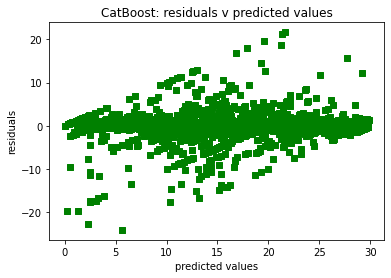

In [21]:
plt.scatter(predictions, predictions - y_test, c = 'green', marker = 's', label = 'Testing data')
plt.xlabel('predicted values')
plt.ylabel('residuals')
plt.title("CatBoost: residuals v predicted values")

-0.028894846511579468


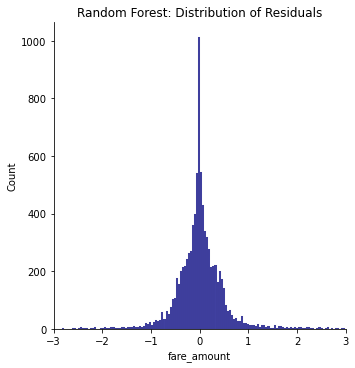

In [22]:
import seaborn as sns
residuals = predictions - y_test
plot = sns.displot(residuals, color = 'navy')
plot.set(title ='Random Forest: Distribution of Residuals', xlim = (-3,3))

resid_mean = (residuals.mean())
print(resid_mean)

### Extracting feature importances

coefficients = pd.DataFrame(
        {"Name":X_train.columns,
         (str(y_train.name)+"_coefs"):regressor.get_feature_importance()}
        )

In [14]:
coefficients = pd.DataFrame(
        {"Name":X_train.columns,
         (str(y_train.name)+"_coefs"):regressor.feature_importances_}
        )

In [15]:
coefficients.sort_values(by = 'fare_amount_coefs', ascending = False)

,Name,fare_amount_coefs
1,time_taken,0.136688
0,trip_distance,0.085845
474,trip_type_1.0,0.051314
438,DOLocationID_229,0.028089
352,DOLocationID_138,0.016566
...,...,...
263,DOLocationID_44,0.000000
254,DOLocationID_35,0.000000
253,DOLocationID_34,0.000000
251,DOLocationID_32,0.000000


The top 3 coefficients that are important in predicting fare amount include trip distance, time taken and trip type.

### Interpreting model results further using SHAP

In [147]:
import shap
# For reference: https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Census%20income%20classification%20with%20XGBoost.html

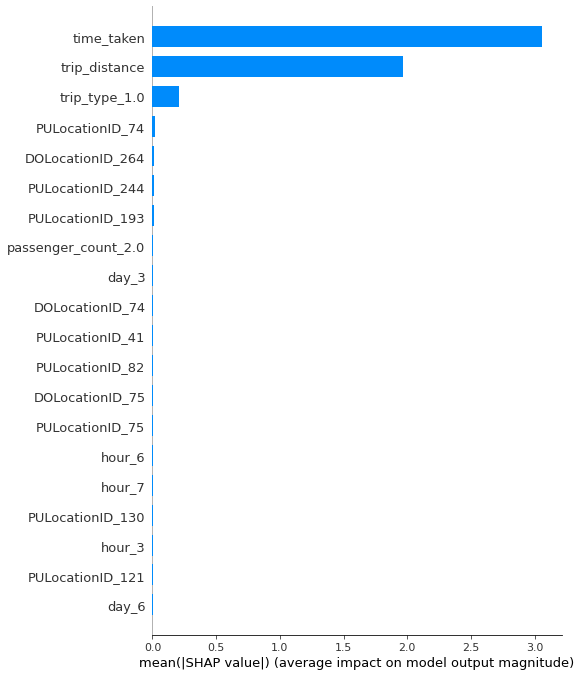

In [148]:
explainer = shap.TreeExplainer(regressor)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

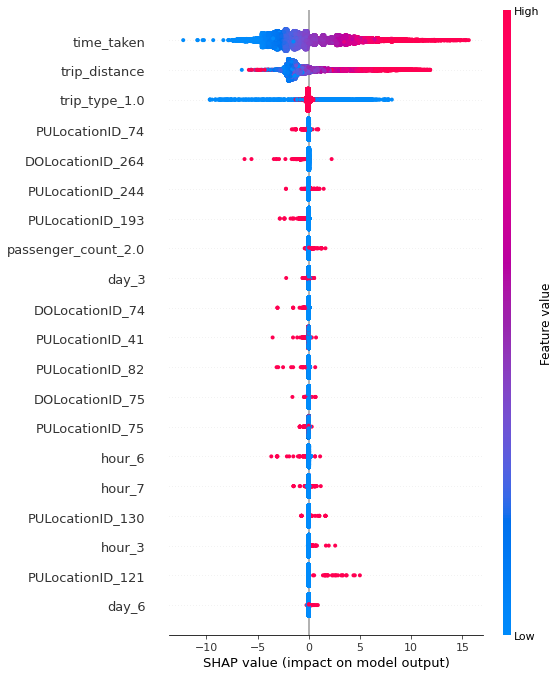

In [149]:
shap.summary_plot(shap_values, X_train)

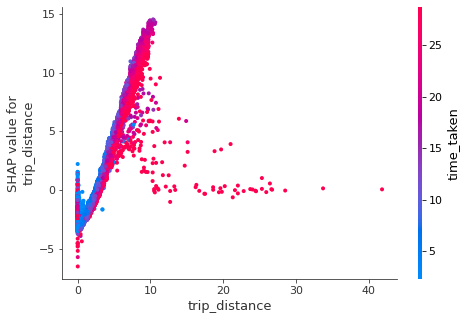

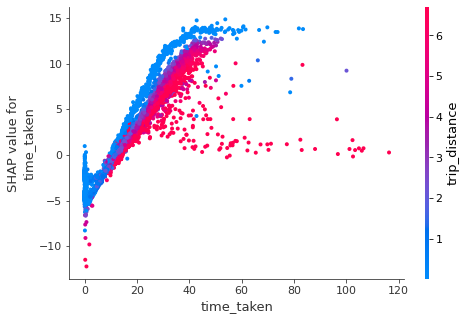

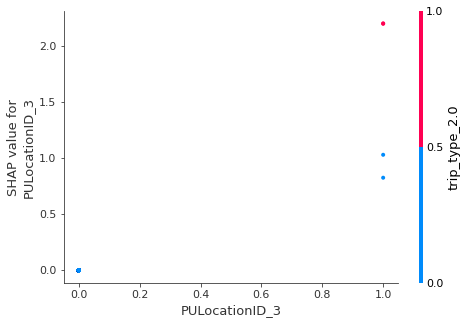

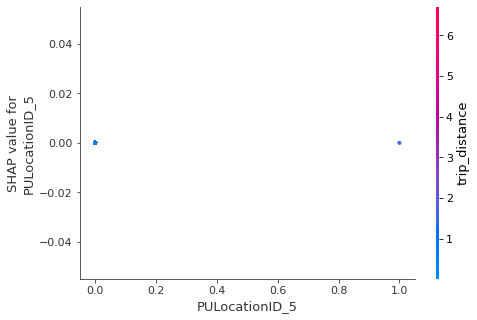

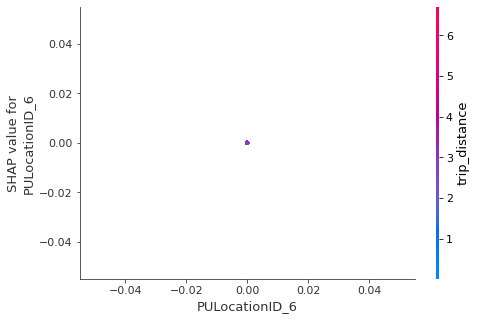

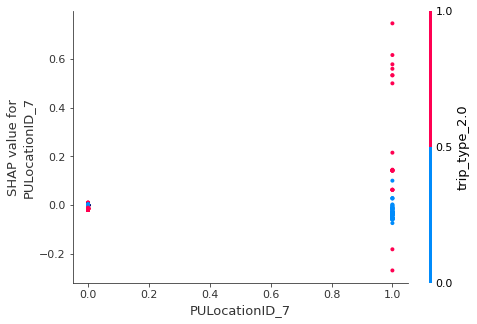

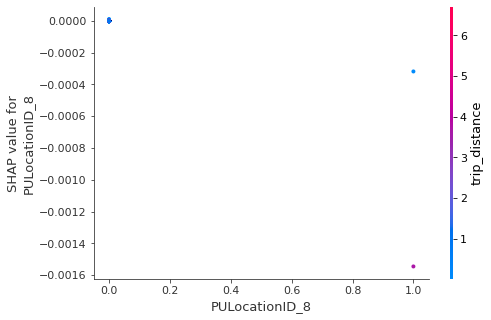

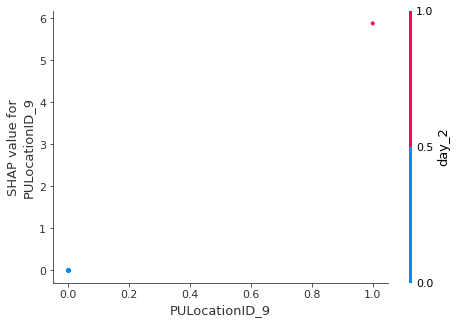

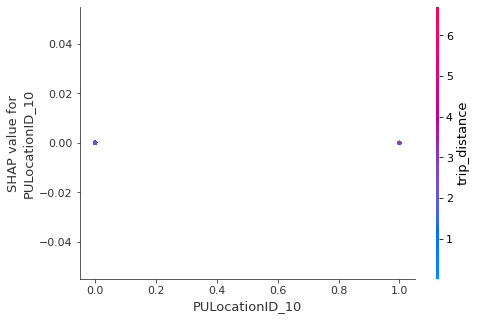

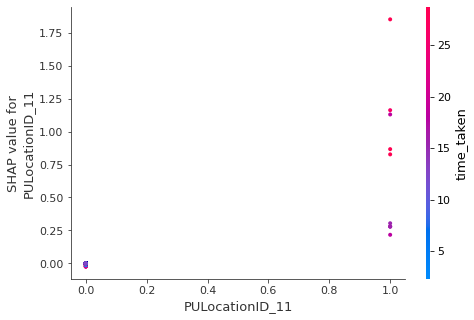

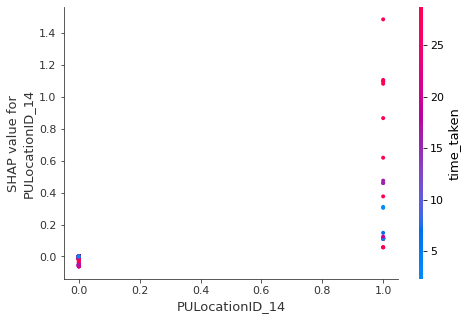

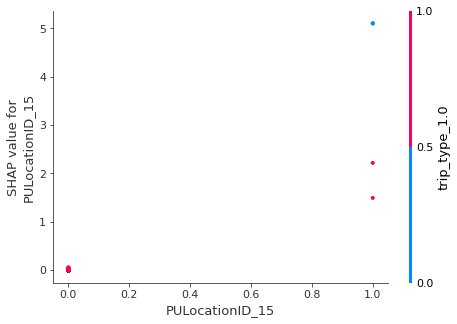

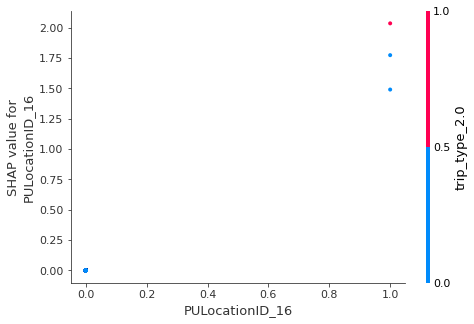

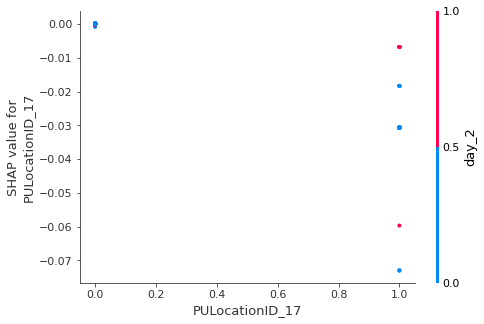

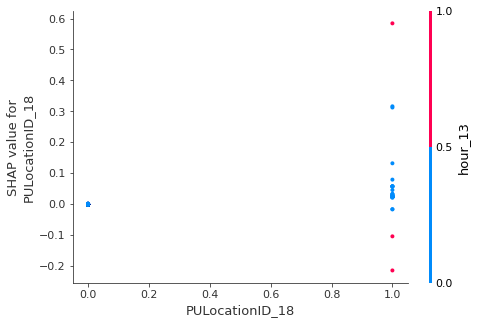

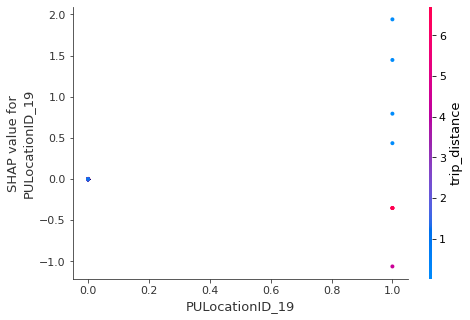

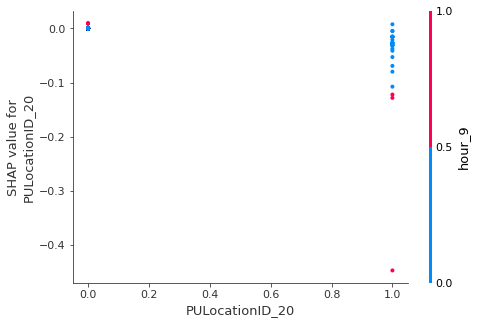

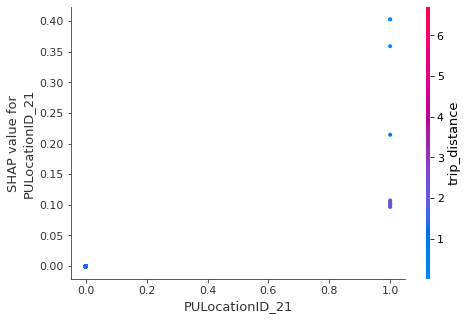

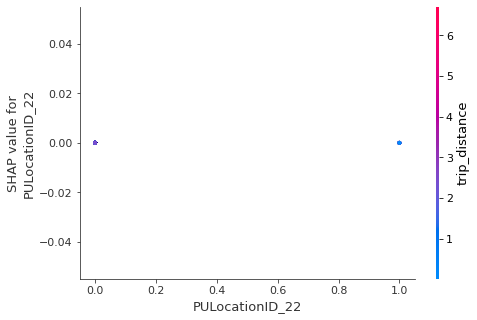

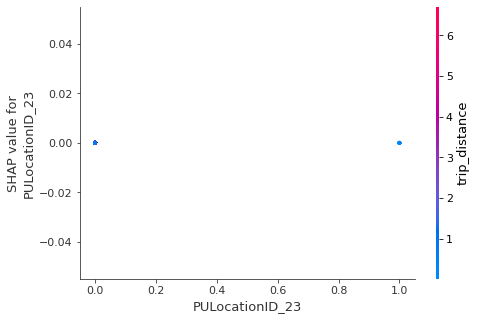

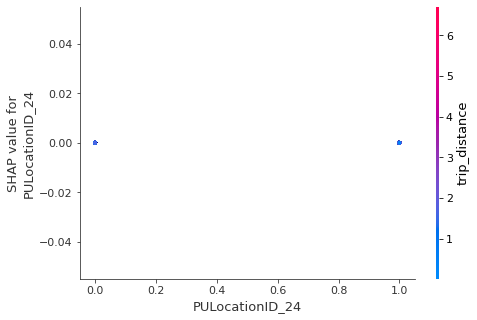

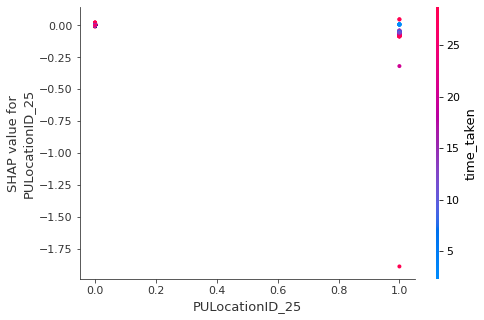

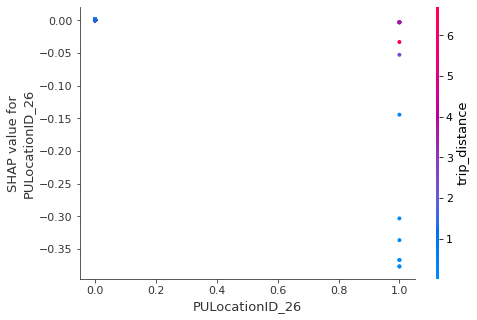

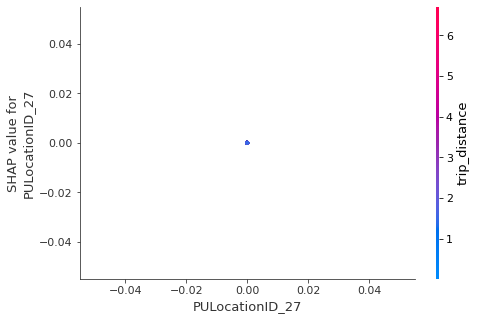

KeyboardInterrupt: 

In [143]:
for name in X_train.columns:
    shap.dependence_plot(name, shap_values, X_train, display_features=X_train)